# Time-Coverage Integrated Plots

This notebook produces **integrated Time Performance & Coverage charts** in Seaborn, as Nitin Yadav originally designed and build in R.

Sebastian Sardina 2023-2024 - ssardina@gmail.com

Notebook originally available at: https://github.com/ssardina-research/coverage-plots

In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

# sys.dont_write_bytecode = True  # prevent creation of .pyc files

STATS_CSV_FILE = "cfond_benchexec_stats.csv"
CSV_FOLDER = os.path.dirname(STATS_CSV_FILE)
CSV_BASENAME = os.path.basename(STATS_CSV_FILE).split(".")[0]

## 1. Load data from CSV tables & select subset

First load CSV table with stats and then project interested set into `df_sel` dataframe. Must have following columns:

- `solver`: name of the solver.
- `domain`: name of the domain.
- `cputime`: CPU time of run.

In [2]:
df = pd.read_csv(STATS_CSV_FILE)

SOLVERS = df["solver"].unique()
DOMAINS = df["domain"].unique()

print("Domains found:", DOMAINS)
print("Solvers found:", SOLVERS)

df.sample(10)

Domains found: ['miner']
Solvers found: ['ASP-fsat' 'ASP-reg']


,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
11,miner_03.yml,cfondasp-reg.MINER-SMALL,1,True,8.259730,6.809772,214.810624,4.697184,14,miner,3,ASP-reg
2,miner_03.yml,cfondasp-fsat.MINER-SMALL,1,True,9.991114,9.451395,267.620352,6.565095,14,miner,3,ASP-fsat
7,miner_08.yml,cfondasp-fsat.MINER-SMALL,1,True,43.557440,38.233510,628.289536,35.444397,18,miner,8,ASP-fsat
14,miner_06.yml,cfondasp-reg.MINER-SMALL,1,True,35.831141,25.932546,391.200768,23.824063,18,miner,6,ASP-reg
13,miner_05.yml,cfondasp-reg.MINER-SMALL,1,True,37.279139,25.542372,316.735488,23.378033,19,miner,5,ASP-reg
10,miner_02.yml,cfondasp-reg.MINER-SMALL,1,True,6.938158,5.690733,195.145728,3.656179,15,miner,2,ASP-reg
1,miner_02.yml,cfondasp-fsat.MINER-SMALL,1,True,8.672183,8.143851,237.326336,5.244447,15,miner,2,ASP-fsat
16,miner_08.yml,cfondasp-reg.MINER-SMALL,1,True,49.302047,34.594408,446.431232,32.486994,18,miner,8,ASP-reg
6,miner_07.yml,cfondasp-fsat.MINER-SMALL,1,True,67.825356,56.313294,704.856064,53.415865,20,miner,7,ASP-fsat
8,miner_09.yml,cfondasp-fsat.MINER-SMALL,1,True,58.068282,49.650738,730.161152,47.696455,19,miner,9,ASP-fsat


Project over selected domains and solvers.

In [3]:
SOLVERS_SEL = SOLVERS   # select all solvers
DOMAINS_SEL = DOMAINS   # select all domains

# SOLVERS_SEL = ['ASP2-fsat']  # select all solvers
# DOMAINS_SEL = ["chain-of-rooms"]  # select all domains

# DOMAINS_SEL = ["spiky-tireworld"]

print("Solvers selected:", SOLVERS_SEL)
print("Domains selected:", DOMAINS_SEL)

df_sel = df.loc[(df.solver.isin(SOLVERS_SEL)) & (df.domain.isin(DOMAINS_SEL))]

df_sel.head()

Solvers selected: ['ASP-fsat' 'ASP-reg']
Domains selected: ['miner']


,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
0,miner_01.yml,cfondasp-fsat.MINER-SMALL,1,True,10.221408,9.274593,239.194112,6.419276,18,miner,1,ASP-fsat
1,miner_02.yml,cfondasp-fsat.MINER-SMALL,1,True,8.672183,8.143851,237.326336,5.244447,15,miner,2,ASP-fsat
2,miner_03.yml,cfondasp-fsat.MINER-SMALL,1,True,9.991114,9.451395,267.620352,6.565095,14,miner,3,ASP-fsat
3,miner_04.yml,cfondasp-fsat.MINER-SMALL,1,True,29.911280,26.532475,482.852864,23.646294,17,miner,4,ASP-fsat
4,miner_05.yml,cfondasp-fsat.MINER-SMALL,1,True,34.188173,29.191234,439.996416,26.374557,19,miner,5,ASP-fsat


Make `solver` column categorical (this will fix the order in plots of its axis, thus making all superimposed plots consistent).

In [4]:
df_sel["solver"] = pd.Categorical(df_sel.solver)

df_sel.dtypes

task              object
run               object
status             int64
solved              bool
cputime          float64
walltime         float64
memory_mb        float64
planner_time     float64
policy_size        int64
domain            object
instance           int64
solver          category
dtype: object

## 2. Compute rich coverage table for plotting

Now we operated on the selected dataframe `df_sel`.

First, count how MANY instances per domain:

In [5]:
selection_index = ['domain']

# count the number of each run per full_domain (e.g., how many lpg runs in Barman-EIGHT50)
count_df = df_sel.groupby(by=selection_index)['solver'].value_counts()

count_df = count_df.reset_index(name="count")

# # transofm the serie into a dataframe and value becomes percent
# coverage_df = coverage_df.mul(100).round(0).rename('percent').reset_index()
# coverage_df = coverage_df.loc[coverage_df.status].reset_index(drop=True)    # keep just the TRUE status (solved!)

count_df
# count_df.query("domain == 'miner' or domain == 'tireworld'")

,domain,solver,count
0,miner,ASP-fsat,9
1,miner,ASP-reg,9


Next calculate **coverage** for each solver run in each domain:

In [6]:
def compute_coverage(df: pd.DataFrame) -> pd.DataFrame:
    # columns to group-by
    selection_index = ["solver", "domain"]

    # count normalized (0-1) the number of grade after grouping for all the other values
    coverage_df = df.groupby(by=selection_index)["solved"].value_counts(normalize=True)

    # transofm the serie into a dataframe and value becomes percent
    coverage_df = coverage_df.mul(100).rename("percent").reset_index()

    # convert the rows that have 100% unsovable (False), to 0% solvable (True)
    #   otherwise, there will be no True solvable for those cases!
    mask_unsolvable = (~coverage_df.solved) & (coverage_df.percent == 100)
    coverage_df.loc[mask_unsolvable, ["solved", "percent"]] = [True, 0]

    # return the % of solvable stats
    return coverage_df.loc[coverage_df.solved].round(
        0
    )

coverage_df = compute_coverage(df_sel)
coverage_df

# SOME FILTERS
coverage_df
# coverage_df.query("solver == 'ASP2-reg'")

/tmp/ipykernel_328497/2580258032.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_df = df.groupby(by=selection_index)["solved"].value_counts(normalize=True)


,solver,domain,solved,percent
0,ASP-fsat,miner,True,100.0
1,ASP-reg,miner,True,100.0


Compute the CPU time mean per domain/solver.

In [7]:
selection_index = ["domain", "solver"]

# mean of cputime for SOLVED instances
cputime_mean_df = df_sel.loc[df_sel.solved].groupby(by=selection_index)["cputime"].mean().round(2)

# mean of cputime for ALL instances
# cputime_mean_df = df_sel.groupby(by=selection_index)["cputime"].mean()

cputime_mean_df = cputime_mean_df.reset_index(name="cputime_mean")

cputime_mean_df

/tmp/ipykernel_328497/1408159.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cputime_mean_df = df_sel.loc[df_sel.solved].groupby(by=selection_index)["cputime"].mean().round(2)


,domain,solver,cputime_mean
0,miner,ASP-fsat,33.26
1,miner,ASP-reg,36.15


Join coverage table with count instances and cpu mean time tables, into a single one:

In [8]:
coverage_df = coverage_df.merge(count_df, how="left")
coverage_df = coverage_df.merge(cputime_mean_df, how="left")

# coverage_df.query("solver == 'ASP2-fsat'")
coverage_df


,solver,domain,solved,percent,count,cputime_mean
0,ASP-fsat,miner,True,100.0,9,33.26
1,ASP-reg,miner,True,100.0,9,36.15


## 3. Build integrated time-coverage plots

Some useful links to make nice charts:

* [Changing plot style and color](https://s3.amazonaws.com/assets.datacamp.com/production/course_15192/slides/chapter4.pdf).
* [Advanced Seaborn: Demystifying the Complex Plots!](https://levelup.gitconnected.com/advanced-seaborn-demystifying-the-complex-plots-537582977c8c#5965 )

Let's first inspect/check the coverage in a random domain:

In [9]:
import random

x = random.choice(coverage_df['domain'].unique())
coverage_df.loc[coverage_df.domain == x]

,solver,domain,solved,percent,count,cputime_mean
0,ASP-fsat,miner,True,100.0,9,33.26
1,ASP-reg,miner,True,100.0,9,36.15


Next, we define the MAIN code for plotting complex combined time-coverage charts across as done with the original R's script from Nitin for ECAI'23.

The final integrated plit is built in three stages:

1. For each domain (e.g., `acrobatics`), draw a _relational scatter subplot_ showing time performance across instances per solver/run.
2. On each subplot, superimpose the cputime mean for each solver.
3. Finally, superimpose coverage bars and % for each solver.

In each subplot, the title shows the full domain with the number of instances run (e.g., `acrobatic (20)` means 20 instances run for `acrobatic` domain).


In [10]:
def plot_coverage(
    runs_df: pd.DataFrame,  # the runs dataframe (result per instance per solver)
    coverage_df: pd.DataFrame,  # coverage stats (domain/solver) dataframe
    title="Time-Coverage Results",
    col_wrap=4,  # how many subplots per row
):
    #############################################
    # PLOT CONFIGURATIONS
    #############################################

    # https://seaborn.pydata.org/tutorial/aesthetics.html
    # https://seaborn.pydata.org/generated/seaborn.set_theme.html
    sns.set_theme()
    # sns.set_style("darkgrid")
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    # sns.set_style(rc={"axes.facecolor": "lightgrey"})

    # col_wrap = 4  # set how many subplots per row (paramter now)
    GAP_SOLVERS = 1.7  # gap between solver names in y axis (lower, more gap)
    ASPECT_SUBPLOTS = 1.2  # aspect ratio of each subplot

    FMT_COVERAGE_LABEL = "%.0f%%"  # coverage with percentage sign %
    # FMT_COVERAGE_LABEL = "%.0f" # coverage without percentage sign %
    MEAN_CPU_COLOR = "black"  # color of the mean label in each solver bar
    BAR_CPUTIME_WIDTH = (
        0  # how thick the bar line for cputime (usually 0 - no bar - just the number)
    )
    BAR_COVERAGE_WIDTH = 1.5  # how thick the bar line for coverage
    MIN_HEIGHT = 4  # minimum height of each subplot

    # DEFINE BOXES USED BELOW
    # box for the title of each subplot
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html#matplotlib.patches.FancyBboxPatch
    bbox_title = dict(
        boxstyle="square", fc="lightgrey", fill=True, color="grey"
    )  # title of each subplot (domain name)
    bbox_coverage = dict(
        boxstyle="round", fc="1", fill=True, color="black"
    )  # style of the coverage label per solver (fc = 1 is white)
    bbox_cputime = dict(boxstyle=None, fc="0.9", fill=True, color="r")

    ####################################################################################
    ## FIRST, produce one scatter subplot per domain with x=cputime and y=solver
    # https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot
    ####################################################################################
    g = sns.relplot(
        data=runs_df.query("solved"),
        kind="scatter",
        s=50,
        x="cputime",
        y="solver",
        col="domain",  # one subplot per domain
        col_wrap=col_wrap,
        height=max(len(SOLVERS_SEL) / GAP_SOLVERS, MIN_HEIGHT),
        aspect=ASPECT_SUBPLOTS,
    )

    # Let's set titles
    g.set_axis_labels("time", "solver")
    g.set_titles(  #   most options are passed to text: https://matplotlib.org/stable/api/text_api.html
        col_template="{col_name}",
        fontweight="demibold",
        ha="center",
        va="center",
        bbox=bbox_title,
    )
    g.figure.suptitle(
        title, ha="center", va="top", fontsize="xx-large", y=1
    )  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html

    print(
        "Finished building scattered plot of cputime. Next overlapping coverage bars..."
    )

    # get all the axes (subplots) of the FaceGrid
    axes = g.axes.flatten()
    sns.set_style("ticks")  # just ticks, no grid from now on...
    plt.grid()  # grid for solver marks

    ####################################################################################
    # SECOND, super-impose cputime mean numbers per solver in each subplot in the grid
    ####################################################################################
    for ax in axes:
        domain = ax.get_title()
        g_cpumean = sns.barplot(  # draw the bar of mean cputime per solver
            data=coverage_df[coverage_df.domain.eq(domain)],
            x="cputime_mean",
            y="solver",
            width=0.0001,
            linewidth=BAR_CPUTIME_WIDTH,
            edgecolor=".5",
            facecolor=(0, 0, 0, 0),
            ax=ax,
        )
        g_cpumean.set(xlabel=None)

        # add cpu mean number per solver, but a bit up to not clash with coverage bar!
        # https://stackoverflow.com/questions/70693878/flexible-placement-of-labels-in-seaborn-barplots
        for p in ax.patches:
            perc = p.get_width()  # the label for the bar
            x = p.get_width()
            y = p.get_y() + p.get_height() / 2

            ax.annotate(perc, (x * 1.1, y - 0.05), color=MEAN_CPU_COLOR)

        # this will add the cpu mean per solver, but will clash with the coverage bar!
        # if len(ax.containers) > 0: # may not be no number!
        #     ax.bar_label(  # set the mean number in the bar at the end (cannot shift tup!)
        #         ax.containers[0],
        #         fmt="%.2f",
        #         label_type="edge",
        #         padding=5,
        #         fontweight="normal",
        #         rotation="horizontal",
        # )

    # comment out to stop here
    # raise SystemExit("Stop right there! Continue below to produce the CSV file if needed.")
    plt.grid()  # grrid for cputime marks

    ####################################################################################
    ## THIRD, super-impose the COVERAGE data in each subplot in the grid as done in
    #   https://stackoverflow.com/a/67612124
    #   we also rename the title of each subplot to include no of instances run
    #   we iterate on each axis and plot a barplot and add annotations/styles to it
    ####################################################################################
    for ax in axes:
        # redo title of subfigure to include number of instances between parenthesis, e.g., BARMAN-EIGHT50 (20)
        domain = ax.get_title()
        no_instances = coverage_df.loc[coverage_df.domain == ax.get_title()][
            "count"
        ].unique()[0]
        ax.set_title(
            f"{domain} ({no_instances})",
            fontweight="demibold",
            ha="center",
            va="center",
            bbox=bbox_title,
        )

        # add bar of coverage % for each run/solver
        ax2 = (
            ax.twiny()
        )  # get a twin y-axies https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
        g2 = sns.barplot(
            data=coverage_df[coverage_df.domain.eq(domain)],
            x="percent",
            y="solver",
            width=0.0001,
            linewidth=BAR_COVERAGE_WIDTH,
            edgecolor=".5",
            facecolor=(0, 0, 0, 0),
            ax=ax2,
        )

        g2.set_xlabel("coverage %", x=0, ha="left")
        g2.set_xlim([0, 100])

        # add box with % of coverage at the end of the barline, if any!
        if len(ax2.containers) > 0:
            ax2.bar_label(
                ax2.containers[0],
                fmt=FMT_COVERAGE_LABEL,
                label_type="edge",
                padding=-5,
                fontweight="normal",
                rotation="horizontal",
                bbox=bbox_coverage,
            )

    # set the axis labels for the whole plot
    g.set_axis_labels("time", "solver")

    # plt.grid()  # grid for coverage marks

    # axes[0].legend().remove()
    # g.set_axis_labels(x_var=None, y_var=None, clear_inner=True)
    sns.despine(left=True, bottom=True)  # no spines at all

    # Save it later, not here.
    # plt.savefig(os.path.join(CSV_FOLDER, f"{SET}_plot.png"))

    plt.tight_layout()  # at the end adjust so everything fits tight but well
    plt.show()

    return g

Next plot all the classical FOND domains, namely the ones used by PRP (2011):

Finished building scattered plot of cputime. Next overlapping coverage bars...


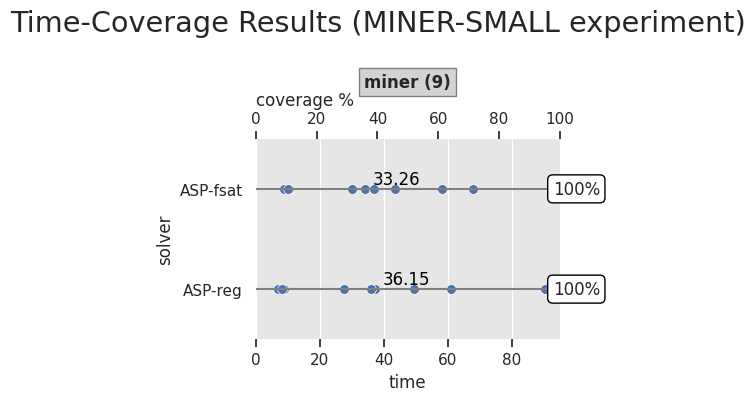

In [11]:
DOMAINS = ["miner"]
g = plot_coverage(
    df_sel.query("domain in @DOMAINS"),
    coverage_df.query("domain in @DOMAINS"),
    title="Time-Coverage Results (MINER-SMALL experiment)",
    col_wrap=min(len(DOMAINS), 4)
)


If happy, then save to file the above plot:

In [12]:
g.savefig(os.path.splitext(STATS_CSV_FILE)[0] + "_plot_CFONDASP.png")
g.savefig(os.path.splitext(STATS_CSV_FILE)[0] + "_plot_CFONDASP.jpg")

### Verification of plot

Double check some of the numbers there to make sure they match!

In [13]:
df_sel.query("solver == 'ASP-fsat' and domain == 'miner' and solved")['cputime'].mean()

coverage_df.query("solver == 'ASP-fsat' and domain == 'miner' and solved")

,solver,domain,solved,percent,count,cputime_mean
0,ASP-fsat,miner,True,100.0,9,33.26


Compute `cputime` mean manually for a particular solver in a domain (so we can verify plots below). Should match label in the plot.

In [14]:
# R has correct scatter points, but wrong mean (shows in S1)
# Python has correct mean, but wrong scatter points (shows in F2)
S = "ASP-reg"
D = "miner"
df_m = df_sel.query("domain == @D and solver == @S and solved")
x = list(df_m["cputime"].values)

print(f"Solver {S}:", np.mean(x))

df_m

Solver ASP-reg: 36.146693666666664


,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
9,miner_01.yml,cfondasp-reg.MINER-SMALL,1,True,8.785078,6.861987,193.794048,4.684582,18,miner,1,ASP-reg
10,miner_02.yml,cfondasp-reg.MINER-SMALL,1,True,6.938158,5.690733,195.145728,3.656179,15,miner,2,ASP-reg
11,miner_03.yml,cfondasp-reg.MINER-SMALL,1,True,8.259730,6.809772,214.810624,4.697184,14,miner,3,ASP-reg
12,miner_04.yml,cfondasp-reg.MINER-SMALL,1,True,27.612465,20.981306,353.783808,18.787554,17,miner,4,ASP-reg
13,miner_05.yml,cfondasp-reg.MINER-SMALL,1,True,37.279139,25.542372,316.735488,23.378033,19,miner,5,ASP-reg
14,miner_06.yml,cfondasp-reg.MINER-SMALL,1,True,35.831141,25.932546,391.200768,23.824063,18,miner,6,ASP-reg
15,miner_07.yml,cfondasp-reg.MINER-SMALL,1,True,90.435200,57.821888,492.613632,55.586493,20,miner,7,ASP-reg
16,miner_08.yml,cfondasp-reg.MINER-SMALL,1,True,49.302047,34.594408,446.431232,32.486994,18,miner,8,ASP-reg
17,miner_09.yml,cfondasp-reg.MINER-SMALL,1,True,60.877285,43.236422,512.655360,41.277615,19,miner,9,ASP-reg
